<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/class3_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
# --------------------------------------------------------------------
# 0) 데이터 로드
# --------------------------------------------------------------------
path = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

df = pd.read_csv(
    path,
    sep=',',
    engine='python',
    header=None,
    names=['user_id','activity','timestamp','x','y','z'],
    on_bad_lines='skip'
)

In [2]:
df = df.copy()

# activity 공백 정리
df['activity'] = df['activity'].astype(str).str.strip()

# x,y,z 문자열 정리 후 숫자 변환
for c in ['x','y','z']:
    df[c] = df[c].astype(str).str.strip().str.rstrip(';')
    df[c] = pd.to_numeric(df[c], errors='coerce')

# 결측 제거
df = df.dropna(subset=['x','y','z']).reset_index(drop=True)

# 시간순 정렬 (유저-시간)
df = df.sort_values(['user_id','timestamp']).reset_index(drop=True)

In [3]:
#라벨 인코딩

le = LabelEncoder()
df['y_enc'] = le.fit_transform(df['activity'])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

Classes: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [4]:
# 유저 분리

train = df[df['user_id'] <= 27].copy()
test  = df[df['user_id'] >  27].copy()

In [5]:
# 표준화

scaler = StandardScaler()
train[['x','y','z']] = scaler.fit_transform(train[['x','y','z']])
test[['x','y','z']]  = scaler.transform(test[['x','y','z']])

In [6]:
# 세그먼트

from scipy.stats import mode

TIME_PERIOD   = 80   # 윈도 길이
STEP_DISTANCE = 40   # 슬라이드 간격(오버랩 50%)

def segments_grouped(df_in, time_steps, step, label_col='y_enc'):
    segs, labs = [], []
    for (uid, act), g in df_in.groupby(['user_id','activity'], sort=False):
        arr = g[['x','y','z',label_col]].to_numpy()
        if len(arr) < time_steps:
            continue
        for i in range(0, len(arr) - time_steps + 1, step):
            win = arr[i:i+time_steps]
            feats = win[:, :3]                               # (T,3)
            lab = mode(win[:, 3], keepdims=False)[0]         # 모드 라벨
            segs.append(feats.astype(np.float32))
            labs.append(int(lab))
    return np.asarray(segs, dtype=np.float32), np.asarray(labs, dtype=np.int32)

x_train, y_train = segments_grouped(train, TIME_PERIOD, STEP_DISTANCE, 'y_enc')
x_test,  y_test  = segments_grouped(test,  TIME_PERIOD, STEP_DISTANCE, 'y_enc')

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test :", x_test.shape,  "y_test :", y_test.shape)

x_train: (19847, 80, 3) y_train: (19847,)
x_test : (7046, 80, 3) y_test : (7046,)


In [7]:
# 원-핫 인코딩

y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_test_oh  = keras.utils.to_categorical(y_test,  num_classes)
print("y_train_oh:", y_train_oh.shape, "y_test_oh:", y_test_oh.shape)

y_train_oh: (19847, 6) y_test_oh: (7046, 6)


In [8]:
# CNN + LSTM 모델

model = keras.Sequential([
    layers.Input(shape=(TIME_PERIOD, 3)),

    # --- CNN 블록 ---
    layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2, padding='same'),   # 80 -> 40

    layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2, padding='same'),   # 40 -> 20

    # --- LSTM 블록 ---
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=False),            # (batch, 20, 64) -> (batch, 64)

    # --- 분류 헤드 ---
    layers.BatchNormalization(epsilon=1e-6),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# 콜백
es  = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 80, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 80, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 40, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 40, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,166 (703.77 KB)

 Trainable params: 179,270 (700.27 KB)

 Non-trainable params: 896 (3.50 KB)

None


In [9]:
# 학습

history = model.fit(
    x_train, y_train_oh,
    validation_split=0.2,
    epochs=100,
    batch_size=192,
    shuffle=True,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8090 - loss: 0.5619 - val_accuracy: 0.1345 - val_loss: 1.9339 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9724 - loss: 0.0950 - val_accuracy: 0.2950 - val_loss: 2.1679 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9874 - loss: 0.0440 - val_accuracy: 0.4597 - val_loss: 1.7069 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9898 - loss: 0.0358 - val_accuracy: 0.7335 - val_loss: 1.0177 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9953 - loss: 0.0188 - val_accuracy: 0.7567 - val_loss: 1.3123 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9936 - loss: 0.0219 - val_accuracy: 0.7635 - val_loss: 1.3644 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9959 - loss: 0.0143 -

[TEST] loss=1.0681  acc=0.8713
              precision    recall  f1-score   support

  Downstairs       0.83      0.70      0.76       713
     Jogging       0.83      0.97      0.90      1977
     Sitting       0.96      0.92      0.94       437
    Standing       0.99      0.99      0.99       393
    Upstairs       0.77      0.74      0.75       787
     Walking       0.92      0.86      0.89      2739

    accuracy                           0.87      7046
   macro avg       0.88      0.86      0.87      7046
weighted avg       0.87      0.87      0.87      7046



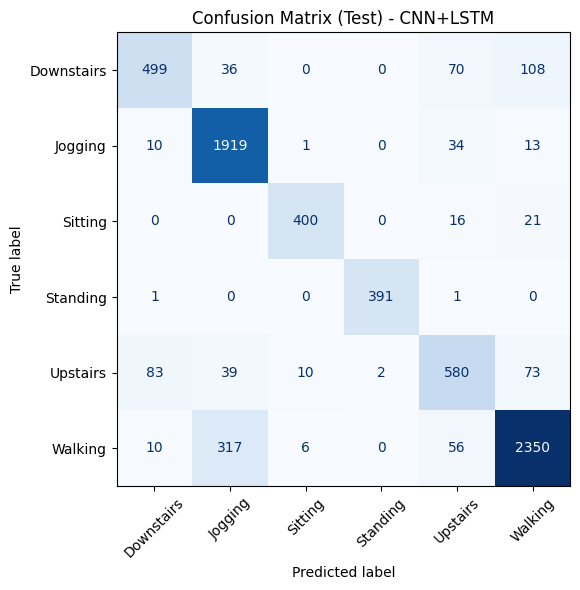

In [10]:
# 평가

test_loss, test_acc = model.evaluate(x_test, y_test_oh, verbose=0)
print(f"[TEST] loss={test_loss:.4f}  acc={test_acc:.4f}")

y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix (Test) - CNN+LSTM')
plt.tight_layout(); plt.show()